# Hypothesis Testing For Customer Discount

## Introduction and Business case

In this project, I will perform Hypothesis Testing to answer some very important questions.
These questions are framed into hypothesis and I will be using the information to figure out the best percentage discount to offer customers. I will use SQLite3 and other statistical methods and tools to provide these discounts.

## Importing Libraries, and gathering data into  Dataframe

In [4]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sms 
import scipy.stats as stat


#creating a connection to the database
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

#querying the database
cur.execute("""SELECT * 
               FROM OrderDetail """)
#Storing results in dataframe
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [5]:
cur.execute("""SELECT name FROM sqlite_master WHERE type='table';""")
df_tables = pd.DataFrame(cur.fetchall(), columns=['Table'])
df_tables

,Table
0,Employee
1,Category
2,Customer
3,Shipper
4,Supplier
5,Order
6,Product
7,OrderDetail
8,CustomerCustomerDemo
9,CustomerDemographic


In [6]:
#effect size
#### Cohen's d
def Cohen_d(group1, group2):
    ''' function takes in 2 groups and return cohen's D'''
    # Compute Cohen's d.
    # group1: Series or NumPy array
    # group2: Series or NumPy array
    # returns a floating point number 
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

## Hypothese 1

Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

$H_0$: Discount has no effect on the quantity of product in an ordered when comparing discount customers and non discount customers

$H_1$: The quantity of product ordered by discount customer is greater than the quantity of product ordered by non discount customers

### Experiment Design  

Spliting data into two groups, Control and experimental groups

In [7]:
#Creating the groups
control = df[df['Discount'] == 0]
ctrl = control['Quantity']
#control_label = control['Discount']


experiment = df[df['Discount'] !=0]
exp = experiment['Quantity']
#exp_label = exp['Discount']

In [8]:
df['discounted'] = np.where(df['Discount']==0,'Full Price', 'Discounted')
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted
0,10248/11,10248,11,14.0,12,0.0,Full Price
1,10248/42,10248,42,9.8,10,0.0,Full Price
2,10248/72,10248,72,34.8,5,0.0,Full Price
3,10249/14,10249,14,18.6,9,0.0,Full Price
4,10249/51,10249,51,42.4,40,0.0,Full Price


Text(0.5, 0, '')

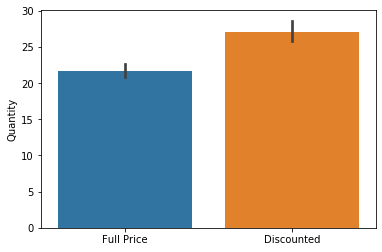

In [9]:
ax = sns.barplot(x='discounted', y='Quantity', data= df)
ax.set_xlabel('')

Text(0.5, 0, '% Discount')

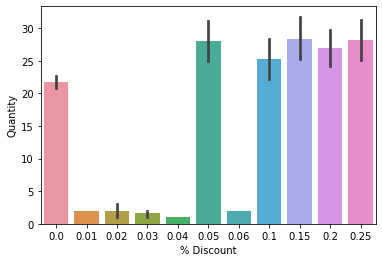

In [10]:
ax = sns.barplot(x='Discount', y='Quantity', data= df)
ax.set_xlabel('% Discount')

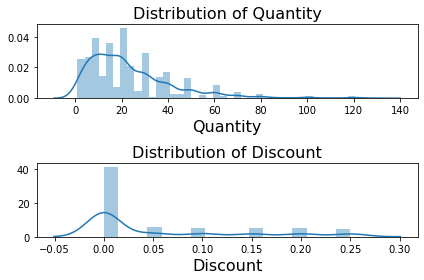

In [11]:
#dist plot of Quantity values
plt.subplot(211)
sns.distplot(df['Quantity'], hist='density')
plt.title('Distribution of Quantity', fontsize=16)
plt.xlabel('Quantity', fontsize=16)
#dist plot of discount values
plt.subplot(212)
sns.distplot(df['Discount'], hist='density')
plt.title('Distribution of Discount', fontsize=16)
plt.xlabel('Discount', fontsize=16)
plt.tight_layout()
plt.show()


### Assumptions

1. Normalitity --
The population data should be normal.

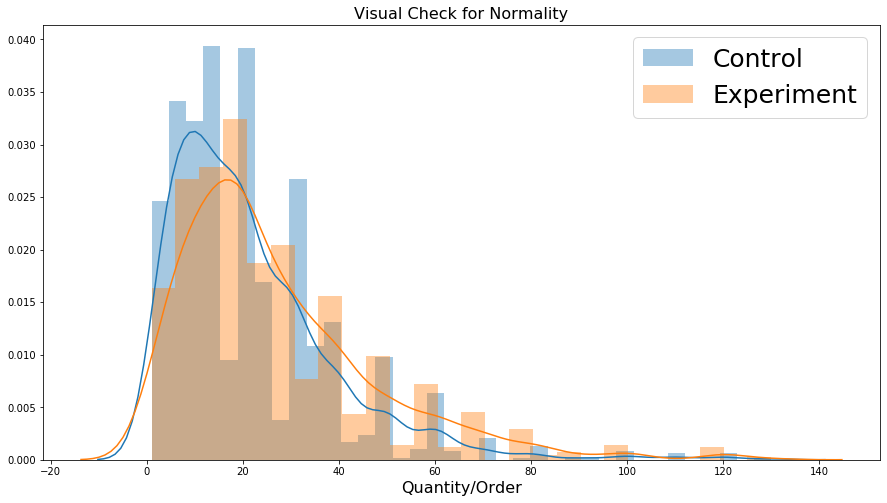

In [13]:
# visual check for normality
plt.figure(figsize=(15, 8))
sns.distplot(ctrl, label='Control')
sns.distplot(exp, label='Experiment',kde=True, hist=True )
plt.title('Visual Check for Normality', fontsize=16)
plt.xlabel('Quantity/Order', fontsize=16)
plt.legend(fontsize=25);


In [10]:
print(stat.normaltest(ctrl))
print(stat.normaltest(exp))

NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)
NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57)


2. Independence -- The quantity of product ordered by a customer is independent of the next customer

3. Random -- Samples must be randomly selected so that every observation has equal chance of selection

### Mann-Whitney U test

Since the groups non parametric we will use Mann-Whhitney U test

In [11]:
stat.mannwhitneyu(ctrl, exp)

MannwhitneyuResult(statistic=461541.0, pvalue=6.629381826999866e-11)

The Pvalue is less that 0.05 so we reject the null hypothesis that Discount has no effect on the quantity of product in an ordered when comparing discount customers and non discount customers

### Effect Size
Cohen's D

In [12]:
abs(Cohen_d(ctrl, exp))

0.2862724481729282

Cohen's D is 0.29 which has a small effect size

Now we know that discount amount has a statistically significant effect on quantity of product ordered

In [13]:
#checking the length of the 2 groups
len_control_data = len(ctrl)
len_exp_data = len(exp)
len_control_data, len_exp_data

(1317, 838)

### Tukey test

In [14]:
data = df['Quantity'].values
labels = df['Discount'].values

#Run Tukey test
model = sms.stats.multicomp.pairwise_tukeyhsd(data,labels)
#model.summary()


In [15]:
tukey_OQD = pd.DataFrame(data=model._results_table[1:], columns=model._results_table[0])
# tukey_OQD.loc[tukey_OQD['reject'] == True]
tukey_OQD

,group1,group2,meandiff,p-adj,lower,upper,reject
0,0.0,0.01,-19.7153,0.9,-80.3306,40.9001,False
1,0.0,0.02,-19.7153,0.9,-62.593,23.1625,False
2,0.0,0.03,-20.0486,0.725,-55.0714,14.9742,False
3,0.0,0.04,-20.7153,0.9,-81.3306,39.9001,False
4,0.0,0.05,6.2955,0.0011,1.5381,11.053,True
5,0.0,0.06,-19.7153,0.9,-80.3306,40.9001,False
6,0.0,0.1,3.5217,0.4269,-1.3783,8.4217,False
7,0.0,0.15,6.6669,0.0014,1.551,11.7828,True
8,0.0,0.2,5.3096,0.0303,0.2508,10.3684,True
9,0.0,0.25,6.525,0.0023,1.3647,11.6852,True


### Conclusion 1

The model produces pvalue(6.629e-11) < alpha, so we reject the null hypothesis. The cohen's D is 0.28 which shows a small effect that can not be seen by the naked eye. In a pairwise tukey comparism we found statistically significant comparism between 0 and each of 5, 15, 20 and 25% discount yield effect on quantity of products ordered.

## Hypothesis 2

Does discount have statistically significance on sales revenue? If so, at what level(s) of discount?

$H_0$: Discount has no effect on the sales revenue

$H_1$: Discount has effect on the sales revenue

### Experiment Design 2

In [16]:
#querying the database
cur.execute("""SELECT Unitprice, Quantity, Discount, Unitprice * Quantity as Sales_revenue
FROM OrderDetail """)
#Storing results in dataframe
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,UnitPrice,Quantity,Discount,Sales_revenue
0,14.0,12,0.0,168.0
1,9.8,10,0.0,98.0
2,34.8,5,0.0,174.0
3,18.6,9,0.0,167.4
4,42.4,40,0.0,1696.0


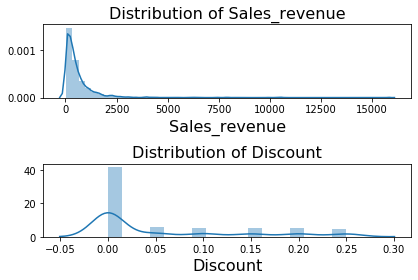

In [17]:
#dist plot of Sales Revenue values
plt.subplot(211)
sns.distplot(df['Sales_revenue'], hist='density')
plt.title('Distribution of Sales_revenue', fontsize=16)
plt.xlabel('Sales_revenue', fontsize=16)
#dist plot of discount values
plt.subplot(212)
sns.distplot(df['Discount'], hist='density')
plt.title('Distribution of Discount', fontsize=16)
plt.xlabel('Discount', fontsize=16)
plt.tight_layout()
plt.show()

Creating groups

In [18]:
#Creating the groups
control1 = df[df['Discount'] == 0]
ctrl1 = control1['Sales_revenue']

experiment1 = df[df['Discount'] !=0]
exp1 = experiment1['Sales_revenue']


In [19]:
df['discounted'] = np.where(df['Discount']==0,'Full Price', 'Discounted')
df.head()

,UnitPrice,Quantity,Discount,Sales_revenue,discounted
0,14.0,12,0.0,168.0,Full Price
1,9.8,10,0.0,98.0,Full Price
2,34.8,5,0.0,174.0,Full Price
3,18.6,9,0.0,167.4,Full Price
4,42.4,40,0.0,1696.0,Full Price


Text(0.5, 0, '')

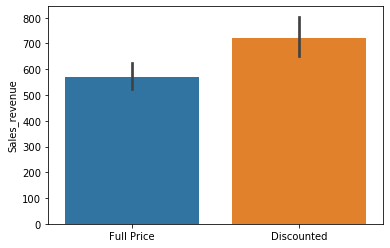

In [20]:
ax = sns.barplot(x='discounted', y='Sales_revenue', data= df)
ax.set_xlabel('')

Text(0.5, 0, '% Discount')

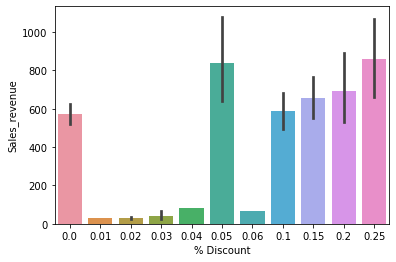

In [21]:
ax = sns.barplot(x='Discount', y='Sales_revenue', data= df)
ax.set_xlabel('% Discount')

### Assumptions

In [14]:
# visual check for normality
plt.figure(figsize=(16, 8))
sns.distplot(ctrl1, label='Control1')
sns.distplot(exp1, label='Experiment1',kde=True, hist=True )
plt.title('Visual Check for Normality', fontsize=15)
plt.xlabel('Sales_revenue', fontsize=15)
plt.legend(fontsize=25);

NameError: name 'ctrl1' is not defined

<Figure size 1152x576 with 0 Axes>

In [23]:
print(stat.normaltest(ctrl1))
print(stat.normaltest(exp1))

NormaltestResult(statistic=1762.622893841281, pvalue=0.0)
NormaltestResult(statistic=1026.5610842353467, pvalue=1.216446154957058e-223)


### Mann-Whitney U-test

In [24]:
stat.mannwhitneyu(ctrl1, exp1)

MannwhitneyuResult(statistic=481980.5, pvalue=3.526900409461034e-07)

The model produces pvalue(3.527e-07) < alpha, so we reject the null hypothesis.

### Effective size

In [25]:
abs(Cohen_d(ctrl1, exp1))

0.14550532043633307

Cohen's D was is found to be 0.145 which has a very small statistically significant effect on sales revenue

### Tukey test

In [26]:
data = df['Sales_revenue'].values
labels = df['Discount'].values

#Run Tukey test
model = sms.stats.multicomp.pairwise_tukeyhsd(data,labels)
model.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.01,-540.0065,0.9,-3870.951,2790.9379,False
0.0,0.02,-539.5065,0.9,-2895.7333,1816.7202,False
0.0,0.03,-528.4565,0.9,-2453.0368,1396.1237,False
0.0,0.04,-489.0065,0.9,-3819.951,2841.9379,False
0.0,0.05,269.9216,0.0362,8.4896,531.3536,True
0.0,0.06,-502.0065,0.9,-3832.951,2828.9379,False
0.0,0.1,17.6565,0.9,-251.6084,286.9214,False
0.0,0.15,85.716,0.9,-195.4149,366.8469,False
0.0,0.2,122.3933,0.9,-155.5997,400.3864,False
0.0,0.25,286.6044,0.045,3.0375,570.1714,True


In [27]:
tukey_OQD = pd.DataFrame(data=model._results_table[1:], columns=model._results_table[0])
tukey_OQD.head(10)


,group1,group2,meandiff,p-adj,lower,upper,reject
0,0.0,0.01,-540.0065,0.9,-3870.951,2790.9379,False
1,0.0,0.02,-539.5065,0.9,-2895.7333,1816.7202,False
2,0.0,0.03,-528.4565,0.9,-2453.0368,1396.1237,False
3,0.0,0.04,-489.0065,0.9,-3819.951,2841.9379,False
4,0.0,0.05,269.9216,0.0362,8.4896,531.3536,True
5,0.0,0.06,-502.0065,0.9,-3832.951,2828.9379,False
6,0.0,0.1,17.6565,0.9,-251.6084,286.9214,False
7,0.0,0.15,85.716,0.9,-195.4149,366.8469,False
8,0.0,0.2,122.3933,0.9,-155.5997,400.3864,False
9,0.0,0.25,286.6044,0.045,3.0375,570.1714,True


### Conclusion

We reject the null hypothesis since pvalue=3.526900409461034e-07). Cohen's D was is found to be 0.145 which has a very small statistically significant effect on sales revenue. statistical significance of 5 and 25% discount produce a very small effect on sales revenue. however there is no difference between 5% and 25% so only 5% discount will save the company money compared to 25%.

## Hypothesis 3

Is there statistically significant difference in the mean sales revenue in North America vs the rest of the countries?

$H_o$: The mean sales for the North America is thesame as the rest of the countries combined

$H_1$: The mean sales from North America is more than the mean sales for rest of the countries.

### Experimental Design 3

Quering data for the rest of the world

In [28]:
#querying the database
cur.execute("""SELECT OrderId, Quantity, UnitPrice, AVG(UnitPrice * Quantity) as Sales
               FROM Customer c LEFT JOIN 'Order' o
               ON o.CustomerId = c.Id
               LEFT JOIN OrderDetail od
               ON od.OrderId = o.Id
               WHERE Region != 'North America' """)
#Storing results in dataframe
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,OrderId,Quantity,UnitPrice,Sales
0,10643,2,12,601.29616


In [29]:
#querying the database
cur.execute("""SELECT OrderId, Region, Quantity, UnitPrice, (UnitPrice * Quantity) as Sales
               FROM Customer c LEFT JOIN 'Order' o
               ON o.CustomerId = c.Id
               LEFT JOIN OrderDetail od
               ON od.OrderId = o.Id
               WHERE Region != 'North America' """)
#Storing results in dataframe
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,OrderId,Region,Quantity,UnitPrice,Sales
0,10643.0,Western Europe,2.0,12.0,24.0
1,10643.0,Western Europe,21.0,18.0,378.0
2,10643.0,Western Europe,15.0,45.6,684.0
3,10692.0,Western Europe,20.0,43.9,878.0
4,10702.0,Western Europe,6.0,10.0,60.0


Quering data for North America

In [30]:
#querying the database
cur.execute("""SELECT OrderId, Region, Quantity, UnitPrice, AVG(UnitPrice * Quantity) as Sales
               FROM Customer c LEFT JOIN 'Order' o
               ON o.CustomerId = c.Id
               LEFT JOIN OrderDetail od
               ON od.OrderId = o.Id
               WHERE Region = 'North America'""")
#Storing results in dataframe
df1 = pd.DataFrame(cur.fetchall())
df1.columns = [x[0] for x in cur.description]
df1.head(10)

,OrderId,Region,Quantity,UnitPrice,Sales
0,10389,North America,30,12,746.840937


In [31]:
#querying the database
cur.execute("""SELECT OrderId, Region, Quantity, UnitPrice, (UnitPrice * Quantity) as Sales
               FROM Customer c LEFT JOIN 'Order' o
               ON o.CustomerId = c.Id
               LEFT JOIN OrderDetail od
               ON od.OrderId = o.Id
               WHERE Region = 'North America'""")
#Storing results in dataframe
df1 = pd.DataFrame(cur.fetchall())
df1.columns = [x[0] for x in cur.description]
df1.head(10)

,OrderId,Region,Quantity,UnitPrice,Sales
0,10389,North America,30,12.0,360.0
1,10389,North America,15,19.2,288.0
2,10389,North America,16,24.8,396.8
3,10389,North America,20,39.4,788.0
4,10410,North America,49,2.0,98.0
5,10410,North America,16,44.0,704.0
6,10411,North America,25,7.7,192.5
7,10411,North America,40,15.5,620.0
8,10411,North America,9,44.0,396.0
9,10431,North America,30,7.6,228.0


In [32]:
df.isnull().sum()

OrderId      6
Region       0
Quantity     6
UnitPrice    6
Sales        6
dtype: int64

In [33]:
df = df.dropna()

In [34]:
df.Sales.isnull().sum()

0

### Two-Sample T-Test

Since we are using the means of the sales, we will use two-sample test

In [35]:
stat.ttest_ind(df.Sales, df1.Sales, equal_var = False)

Ttest_indResult(statistic=-2.333670945823791, pvalue=0.019947978580506773)

The model produces pvalue(0.02) < alpha, so we reject the null hypothesis.

### Effective size

In [36]:
abs(Cohen_d(df.Sales, df1.Sales))

0.14048978188173492

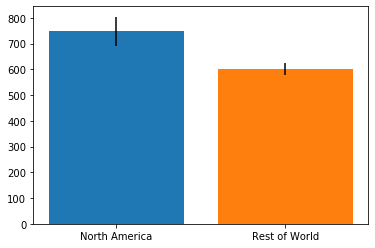

In [37]:
plt.bar(x = 'North America', height = df1.Sales.mean(),
        yerr = stat.sem(df1.Sales))
plt.bar(x = 'Rest of World', height = df.Sales.mean(), yerr = stat.sem(df.Sales))
plt.show();

### Conclusion

The model produces pvalue(0.02) < alpha, so we reject the null hypothesis that states "The mean sales for the North America is thesame as the rest of the countries combined". The cohen's D is 0.14 which shows a very small effect that can not be seen by the naked eye.


## Hypothesis 4

Is there a statistical difference between the mean quantity of products ordered by customers from North America vs the rest of the world?

$H_o$: There is no difference in the mean quantity ordered by customers in North America vs the world.

$H_1$: The mean quantity of product ordered by customers in North America is greater than the mean quantity ordered by the rest of the world.

In [38]:
#querying the database
cur.execute("""SELECT OrderId, Region, AVG(Quantity)
               FROM Customer c LEFT JOIN 'Order' o
               ON o.CustomerId = c.Id
               LEFT JOIN OrderDetail od
               ON od.OrderId = o.Id
               WHERE Region != 'North America'
                """)
#Storing results in dataframe
df1 = pd.DataFrame(cur.fetchall())
df1.columns = [x[0] for x in cur.description]
df1.head()

,OrderId,Region,AVG(Quantity)
0,10643,Western Europe,23.259237


In [39]:
#querying the database
cur.execute("""SELECT OrderId, Region, Quantity
               FROM Customer c LEFT JOIN 'Order' o
               ON o.CustomerId = c.Id
               LEFT JOIN OrderDetail od
               ON od.OrderId = o.Id
               WHERE Region != 'North America'""")
#Storing results in dataframe
df2 = pd.DataFrame(cur.fetchall())
df2.columns = [x[0] for x in cur.description]
df2.head(10)

,OrderId,Region,Quantity
0,10643.0,Western Europe,2.0
1,10643.0,Western Europe,15.0
2,10643.0,Western Europe,21.0
3,10692.0,Western Europe,20.0
4,10702.0,Western Europe,6.0
5,10702.0,Western Europe,15.0
6,10835.0,Western Europe,2.0
7,10835.0,Western Europe,15.0
8,10952.0,Western Europe,2.0
9,10952.0,Western Europe,16.0


In [40]:
#querying the database
cur.execute("""SELECT OrderId, Region, AVG(Quantity)
               FROM Customer c LEFT JOIN 'Order' o
               ON o.CustomerId = c.Id
               LEFT JOIN OrderDetail od
               ON od.OrderId = o.Id
               WHERE Region = 'North America'
                """)
#Storing results in dataframe
df11 = pd.DataFrame(cur.fetchall())
df11.columns = [x[0] for x in cur.description]
df11.head(10)

,OrderId,Region,AVG(Quantity)
0,10389,North America,26.496487


In [41]:
#querying the database
cur.execute("""SELECT OrderId, Region, Quantity
               FROM Customer c LEFT JOIN 'Order' o
               ON o.CustomerId = c.Id
               LEFT JOIN OrderDetail od
               ON od.OrderId = o.Id
               WHERE Region = 'North America' """)
#Storing results in dataframe
df3 = pd.DataFrame(cur.fetchall())
df3.columns = [x[0] for x in cur.description]
df3.head()

,OrderId,Region,Quantity
0,10389,North America,15
1,10389,North America,16
2,10389,North America,20
3,10389,North America,30
4,10410,North America,16


In [42]:
df2.isnull().sum()

OrderId     6
Region      0
Quantity    6
dtype: int64

In [43]:
df3.isnull().sum()

OrderId     0
Region      0
Quantity    0
dtype: int64

In [44]:
df2 = df2.dropna()

In [45]:
df2.Quantity.isnull().sum()

0

### Experiment Design 4

In [46]:
len(df2.Quantity), len(df3.Quantity)

(1651, 427)

Because the group sizes are different, we can use the welch's test without testing for equal variance

### Two-Sample Test

In [47]:
stat.ttest_ind(df2.Quantity, df3.Quantity, equal_var = False)

Ttest_indResult(statistic=-2.7427622902755946, pvalue=0.006282273797625049)

The model produces pvalue(0.0063) < alpha, so we reject the null hypothesis.

### Effective size

In [48]:
abs(Cohen_d(df2.Quantity, df3.Quantity))

0.16937825416696875

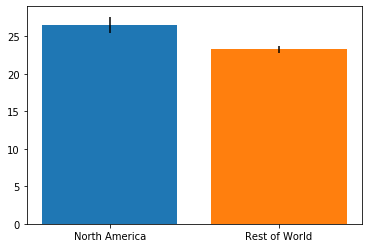

In [49]:
plt.bar(x = 'North America', height = df3.Quantity.mean(),
        yerr = stat.sem(df3.Quantity))
plt.bar(x = 'Rest of World', height = df2.Quantity.mean(), yerr = stat.sem(df2.Quantity))
plt.show();

### Conclusion 

The model produces pvalue(0.006) < alpha, so we reject the null hypothesis. The cohen's D is 0.17 which shows a very small effect that can not be seen by the naked eye.